In [1]:
import os
import random
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.ndimage import gaussian_filter1d
from side_info_decoding.utils import set_seed, load_data_from_pids

seed = 666
set_seed(seed)

In [2]:
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader
from ibllib.atlas import AllenAtlas

In [3]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    '143dd7cf-6a47-47a1-906d-927ad7fe9117',
    '16799c7a-e395-435d-a4c4-a678007e1550',
    '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    '1e176f17-d00f-49bb-87ff-26d237b525f1',
    '31f3e083-a324-4b88-b0a4-7788ec37b191'
]

In [ ]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="all",
    behavior="choice",
    data_type="all_ks",
    t_before=.5,
    t_after=1.5,
    n_t_bins=50,
    align_time_type='stimOn_times',
    normalize_input=False
)

In [4]:
# np.save("X_dict.npy", X_dict)
# np.save("Y_dict.npy", Y_dict)
X_dict = np.load("X_dict.npy", allow_pickle=True).item()
Y_dict = np.load("Y_dict.npy", allow_pickle=True).item()

In [335]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

all_X, all_depths, roi_depths = [], [], []
for pid in pids:
    print(pid)
    X = X_dict[pid]
    K, C, T = X.shape
    X = scaler.fit_transform(X.reshape((-1,C*T))).reshape(-1,C,T)
    choices = Y_dict[pid]
    ba = AllenAtlas()
    one = ONE()
    eid, probe = one.pid2eid(pid)
    sl = SpikeSortingLoader(pid = pid, one = one, atlas = ba)
    spikes, clusters, channels = sl.load_spike_sorting()
    clusters = sl.merge_clusters(spikes, clusters, channels)
    tmp_Xs, tmp_depths = [], []
    for region in ["po", "lp", "dg", "ca1", "vis"]:
        mask = np.array([roi_name.lower().find(region) for roi_name in clusters.acronym]) == 0
        # tmp_depths.append([np.argwhere(mask == 1).min(), np.argwhere(mask == 1).max()])
        rank = np.argsort(clusters.depths[mask])
        tmp_X = X[:,mask,:][:,rank,:]
        tmp_depths.append(tmp_X.shape[1])
        tmp_Xs.append(tmp_X)
    roi_depths.append(tmp_depths)
    all_X.append(np.hstack(tmp_Xs))
    all_depths.append(clusters.depths)

dab512bd-a02d-4c1f-8dbc-9155a163efc0
febb430e-2d50-4f83-87a0-b5ffbb9a4943
523f8301-4f56-4faf-ab33-a9ff11331118
84bb830f-b9ff-4e6b-9296-f458fb41d160
0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a
143dd7cf-6a47-47a1-906d-927ad7fe9117
16799c7a-e395-435d-a4c4-a678007e1550
1a60a6e1-da99-4d4e-a734-39b1d4544fad
1e176f17-d00f-49bb-87ff-26d237b525f1
31f3e083-a324-4b88-b0a4-7788ec37b191


In [336]:
selected_pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    # "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    '143dd7cf-6a47-47a1-906d-927ad7fe9117',
    # '16799c7a-e395-435d-a4c4-a678007e1550',
    '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    '1e176f17-d00f-49bb-87ff-26d237b525f1',
    '31f3e083-a324-4b88-b0a4-7788ec37b191'
]

/tmp/ipykernel_56604/519041571.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


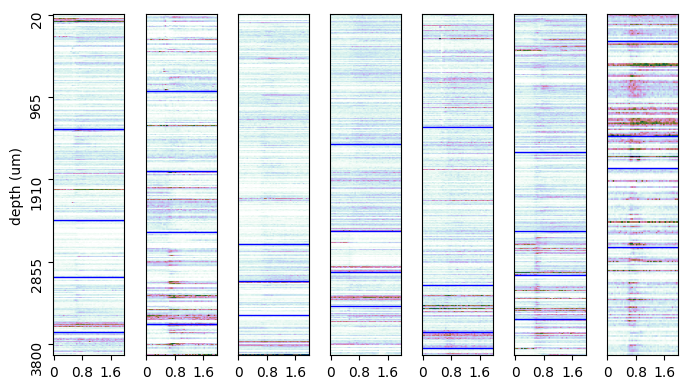

In [339]:
fig, axes = plt.subplots(1, len(selected_pids)-1, figsize=(7,4))

colors = ["red", "blue", "k", "darkorange"]

idxs = [0,1,2,4,5,7,8,9]
for i, ax in enumerate(axes):
    im = ax.imshow(all_X[idxs[i]].mean(0), aspect="auto", cmap="cubehelix_r")
    pos = 0
    for j, region in enumerate(["po", "lp", "dg", "ca1", "vis"]):
        pos += roi_depths[idxs[i]][j]
        if region != "vis":
            ax.axhline(pos, c="blue", linestyle="-", linewidth=1.)
    ax.set_yticks([], [])
    if i != 0:
        ax.set_yticks([], [])
    else:
        ax.set_yticks([0, 100, 200, 300, 400], 
                      np.linspace(all_depths[0].min(), all_depths[0].max(), 5).astype(int),
                      rotation=90)
        ax.set_ylabel("depth (um)")
    # ax.set_ylim(0, pos+1)
    ax.set_xticks([0, 20, 40], [0, 0.8, 1.6])
    plt.tight_layout()
plt.savefig("./plots/spike_count_per_region.png", dpi=200)

In [328]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

all_X, all_depths, roi_depths = [], [], []
for pid in pids:
    print(pid)
    X = X_dict[pid]
    K, C, T = X.shape
    X = scaler.fit_transform(X.reshape((-1,C*T))).reshape(-1,C,T)
    choices = Y_dict[pid]
    ba = AllenAtlas()
    one = ONE()
    eid, probe = one.pid2eid(pid)
    sl = SpikeSortingLoader(pid = pid, one = one, atlas = ba)
    spikes, clusters, channels = sl.load_spike_sorting()
    clusters = sl.merge_clusters(spikes, clusters, channels)
    tmp_Xs, tmp_depths = [], []
    for region in ["po", "lp", "dg", "ca1", "vis"]:
        mask = np.array([roi_name.lower().find(region) for roi_name in clusters.acronym]) == 0
        # tmp_depths.append([np.argwhere(mask == 1).min(), np.argwhere(mask == 1).max()])
        rank = np.argsort(clusters.depths[mask])
        tmp_X = X[:,mask,:][:,rank,:]
        tmp_depths.append(tmp_X.shape[1])
        tmp_Xs.append(tmp_X)
    roi_depths.append(tmp_depths)
    all_X.append(tmp_Xs)
    all_depths.append(clusters.depths)

dab512bd-a02d-4c1f-8dbc-9155a163efc0
febb430e-2d50-4f83-87a0-b5ffbb9a4943
523f8301-4f56-4faf-ab33-a9ff11331118
84bb830f-b9ff-4e6b-9296-f458fb41d160
0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a
143dd7cf-6a47-47a1-906d-927ad7fe9117
16799c7a-e395-435d-a4c4-a678007e1550
1a60a6e1-da99-4d4e-a734-39b1d4544fad
1e176f17-d00f-49bb-87ff-26d237b525f1
31f3e083-a324-4b88-b0a4-7788ec37b191


In [329]:
selected_pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    # "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    '143dd7cf-6a47-47a1-906d-927ad7fe9117',
    # '16799c7a-e395-435d-a4c4-a678007e1550',
    '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    '1e176f17-d00f-49bb-87ff-26d237b525f1',
    '31f3e083-a324-4b88-b0a4-7788ec37b191'
]

/tmp/ipykernel_56604/3672195138.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


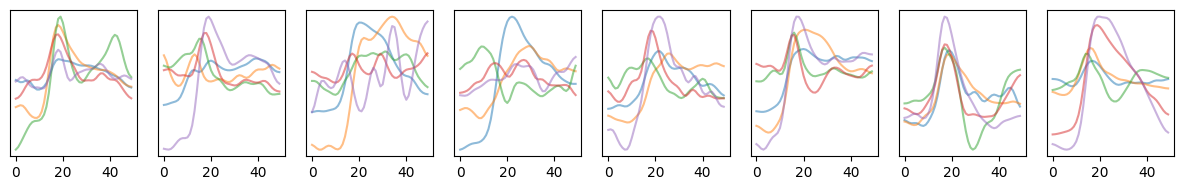

In [270]:
import tensortools as tt

fig, axes = plt.subplots(1, len(selected_pids), figsize=(12,2))

colors = ["red", "blue", "k", "darkorange"]

idxs = [0,1,2,4,5,7,8,9]
for i, ax in enumerate(axes):
    factors = []
    for j in range(len(["po", "lp", "dg", "ca1", "vis"])):
        U = tt.cp_als(all_X[idxs[i]][j], rank=1, verbose=False)
        factors_tt = U.factors.factors
        factors.append(factors_tt[-1].flatten())
    l2_norm = np.array([np.linalg.norm(factors[i]) for i in range(len(factors))])
    smooth_proj = np.array(factors) / l2_norm.reshape(-1,1)
    for j in range(len(["po", "lp", "dg", "ca1", "vis"])):
        # ax.plot(np.abs(gaussian_filter1d(smooth_proj[j], 2.)), alpha=j*.2)
        ax.plot(np.abs(gaussian_filter1d(smooth_proj[j], 2.)), alpha=.5)
    ax.set_yticks([], [])
    plt.tight_layout()

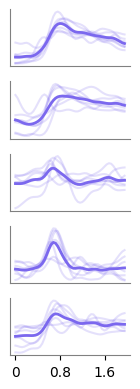

In [334]:
import tensortools as tt

fig, axes = plt.subplots(5, 1, figsize=(1.5, 4))

colors = ["red", "blue", "k", "darkorange"]

# idxs = [0,1,2,4,5,7,8,9]
idxs = [0,1,2,4,5,7,8]
for j in range(len(["po", "lp", "dg", "ca1", "vis"])):
    factors = []
    for i in range(len(idxs)):
        U = tt.cp_als(all_X[idxs[i]][j], rank=1, verbose=False)
        factors_tt = U.factors.factors
        smooth_proj = np.abs(gaussian_filter1d(factors_tt[-1].flatten(), 2.))
        factors.append(smooth_proj)
    l2_norm = np.array([np.linalg.norm(factors[i]) for i in range(len(factors))])
    smooth_proj = np.array(factors) / l2_norm.reshape(-1,1)
    axes[j].plot(smooth_proj.squeeze().T, c="mediumslateblue", alpha=.2)
    axes[j].plot(smooth_proj.mean(0), c="mediumslateblue", alpha=1., linewidth=2)
    axes[j].set_yticks([], [])
    axes[j].spines[['right', 'top']].set_visible(False)
    axes[j].spines['bottom'].set_color('grey')
    axes[j].spines['left'].set_color('grey')
    if j == 4:
        axes[j].set_xticks([0, 20, 40], [0, 0.8, 1.6])
    else:
        axes[j].set_xticks([], [])
plt.tight_layout()
plt.savefig("./plots/demixed_tca.png", dpi=200)

In [4]:
import hmmlearn
from pathlib import Path
from hmmlearn.hmm import CategoricalHMM

In [71]:
X_dict, Y_dict = load_data_from_pids(
    [pids[5]],
    brain_region="dg",
    behavior="choice",
    data_type="all_ks",
    t_before=.5,
    t_after=1.5,
    n_t_bins=50,
    align_time_type='stimOn_times',
    normalize_input=False,
)

pulling data from ibl database ..
eid: 3638d102-e8b6-4230-8742-e548cd87a949
pid: 143dd7cf-6a47-47a1-906d-927ad7fe9117
number of trials found: 605 (active: 605)
prior for this session is not found.
found 605 trials from 32.91 to 4786.28 sec.
found 63 Kilosort units in region dg


Compute spike count: 100%|██████████████████| 605/605 [00:00<00:00, 2802.86it/s]


In [72]:
X_dict, block = load_data_from_pids(
    [pids[5]],
    brain_region="dg",
    behavior="pLeft",
    data_type="all_ks",
    t_before=.5,
    t_after=1.5,
    n_t_bins=50,
    align_time_type='stimOn_times',
    normalize_input=False,
)

pulling data from ibl database ..
eid: 3638d102-e8b6-4230-8742-e548cd87a949
pid: 143dd7cf-6a47-47a1-906d-927ad7fe9117
number of trials found: 605 (active: 605)
prior for this session is not found.
found 605 trials from 32.91 to 4786.28 sec.
found 63 Kilosort units in region dg


Compute spike count: 100%|██████████████████| 605/605 [00:00<00:00, 2789.92it/s]


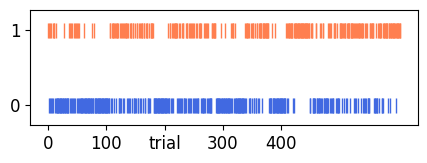

In [73]:
choices = Y_dict[pids[5]]

plt.figure(figsize=(5, 1.5))
plt.eventplot(
    np.where(choices == 1.), 
    colors="coral", lineoffsets=1, linelengths=.2, linewidth=1., 
)
plt.eventplot(
    np.where(choices == 0.), 
    colors="royalblue", lineoffsets=0, linelengths=.2, linewidth=1.,
)
plt.yticks([0, 1], [0, 1], fontsize=12)
plt.xticks([0, 100, 200, 300, 400], [0, 100, "trial", 300, 400], fontsize=12)
# plt.savefig("./plots/observed_choice.png", dpi=100)
plt.show()

In [369]:
hmm = CategoricalHMM(n_components=2)
hmm.fit(choices.reshape(-1,1))
states = hmm.predict_proba(choices.reshape(-1,1))

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
X = X_dict[pids[5]]
K, C, T = X.shape

probs = []
kf = KFold(n_splits=5, random_state=None, shuffle=False)
for i, (train, test) in enumerate(kf.split(X)):
    X_train, X_test = X[train], X[test]
    y_train, y_test = choices[train], choices[test]
    lr = LogisticRegression()
    lr.fit(X_train.reshape(-1,C*T), y_train)
    y_prob = lr.predict_proba(X_test.reshape(-1,C*T))
    probs.append(y_prob[:,1])
probs = np.hstack(probs)

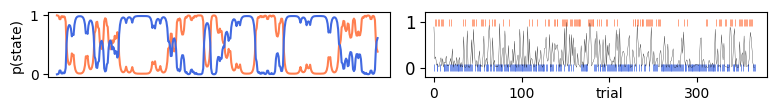

In [371]:
fig, axes = plt.subplots(1,2,figsize=(8, 1.2))
axes[0].plot(states.T[0], c="coral")
axes[0].plot(states.T[1], c="royalblue")
# axes[0].set_xticks([0, 100, 200, 300, 400], [0, 100, "trial", 300, 400], fontsize=12)
axes[0].set_xticks([],[])
axes[0].set_xlim(-10, 380)
axes[0].set_ylabel("p(state)")

axes[1].eventplot(
    np.where(choices == 1.), 
    colors="coral", lineoffsets=1, linelengths=.15, linewidth=.5, 
)
axes[1].eventplot(
    np.where(choices == 0.), 
    colors="royalblue", lineoffsets=0, linelengths=.15, linewidth=.5,
)
axes[1].plot(probs, c="k", alpha=1., linewidth=.2)
axes[1].set_yticks([0, 1], [0, 1], fontsize=12)
axes[1].set_xticks([0, 100, 200, 300, 400], [0, 100, "trial", 300, 400])
axes[1].set_xlim(-10, 380)
plt.tight_layout()
# plt.savefig("./plots/observed_choice.png", dpi=100)

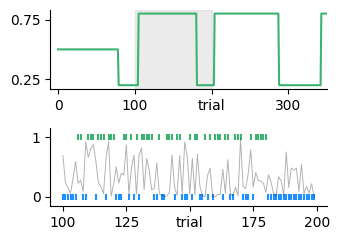

In [75]:
fig, axes = plt.subplots(2,1,figsize=(3.5, 2.5))
axes[0].plot(block[pids[5]], c="mediumseagreen")
# axes[0].plot(states.T[1], c="dodgerblue")
axes[0].axvspan(100, 200, alpha=.3, color="silver")
axes[0].set_xticks([0, 100, 200, 300, 400], [0, 100, "trial", 300, 400])
axes[0].set_xlim(-10, 350)
axes[0].set_yticks([0.25, 0.75], [0.25, 0.75])

axes[1].eventplot(
    np.where(choices[100:200] == 1.), 
    colors="mediumseagreen", lineoffsets=1, linelengths=.1, linewidth=1.5, 
)
axes[1].eventplot(
    np.where(choices[100:200] == 0.), 
    colors="dodgerblue", lineoffsets=0, linelengths=.1, linewidth=1.5,
)
axes[1].plot(probs[100:200], c="k", alpha=.3, linewidth=.7)
axes[1].set_xticks([0, 25, 50, 75, 100], [100, 125, "trial", 175, 200])
for ax in axes:
    ax.spines[['right', 'top']].set_visible(False)
    # ax.spines['bottom'].set_color('grey')
    # ax.spines['left'].set_color('grey')
plt.tight_layout()
plt.savefig("./plots/example_behavior_states_3.png", dpi=200)

In [416]:
X_dict, Y_dict = load_data_from_pids(
    [pids[0]],
    brain_region="all",
    behavior="prior",
    data_type="all_ks",
    t_before=1.,
    t_after=.5,
    n_t_bins=30,
    align_time_type='stimOn_times',
    normalize_input=False,
    prior_path = "/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/paper_repro_ephys_data/figure9_10/priors/"
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 367 (active: 367)
found 367 trials from 17.56 to 2310.24 sec.


Compute spike count: 100%|███████████████████| 367/367 [00:02<00:00, 164.49it/s]


In [417]:
prior = Y_dict[pids[0]]

In [434]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
X = X_dict[pids[0]]
K, C, T = X.shape

preds = []
kf = KFold(n_splits=5, random_state=None, shuffle=False)
for i, (train, test) in enumerate(kf.split(X)):
    X_train, X_test = X[train], X[test]
    y_train, y_test = prior[train], choices[test]
    lr = Ridge(alpha=1e3)
    lr.fit(X_train.reshape(-1,C*T), y_train)
    y_pred = lr.predict(X_test.reshape(-1,C*T))
    preds.append(y_pred)
preds = np.hstack(preds)

In [435]:
preds = (preds - preds.min()) / (preds.max() - preds.min())

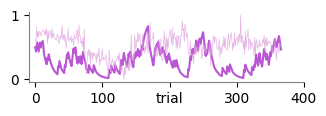

In [437]:
fig, axes = plt.subplots(1,1,figsize=(3.5, 1.25))
axes.plot(prior, c="mediumorchid")
axes.set_xticks([], [])
axes.set_xlim(-10, 380)
axes.plot(1-preds, c="plum", alpha=.8, linewidth=.5)
axes.set_xticks([0, 100, 200, 300, 400], [0, 100, "trial", 300, 400])
axes.spines[['right', 'top']].set_visible(False)
axes.spines['bottom'].set_color('grey')
axes.spines['left'].set_color('grey')
plt.tight_layout()
plt.savefig("./plots/example_prior_1.png", dpi=200)